In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pymc as pm

In [2]:
def load_data(n_years=None):
    df = pd.read_excel("./data/d18O NGRIP 21.04.24.xlsx", 
                       sheet_name="Raw Data", header=None, 
                       engine="openpyxl")
    
    df_data = df.iloc[10:6124,2:4]
    df_data.columns = ["Age", "d18o"]
    
    # set first year to 0 and choose years less than "n_years"
    df_data["Age"] -= min(df_data["Age"])
    if n_years is not None:
        df_data = df_data[df_data["Age"] <= n_years]
    
    # center data
    df_data["d18o"] -= np.mean(df_data["d18o"]) 
    
    t = df_data["Age"].values.astype("float")
    y = df_data["d18o"].values.astype("float")

    return t, y

def extract_harmonics(t, y, n_harmonics=3, snr_threshold=50, n_samples=1000, n_tune=1000, 
                 n_chains=2, target_accept=0.95, save_params=False):
    residuals = y.copy()

    harmonics = []
    params = {"P": [], "dP": [], "A": [], "dA": [], "Phi": [], "dPhi": []}
    for i in range(n_harmonics):
        # feedback
        print(60 * "-")
        text = f" Iteration number {i+1} of {n_harmonics} "
        left_text = " " * ((60 - len(text))//2)
        right_text = " " * (60 - len(left_text))
        print(f"{left_text}{text}{right_text}")
        print(60 * "-")

        # find dominant period and check if residuals are noise-like
        P_guess = dominant_period(t, residuals, snr_threshold)
        if P_guess is None:
            break

        # fit harmonic
        fit_params, trace = fit_harmonic(t, residuals, P_guess, n_samples=n_samples, 
                                         n_tune=n_tune, n_chains=n_chains, 
                                         target_accept=target_accept)
        P, dP, A, dA, Phi, dPhi = fit_params
        harmonic = build_model(t, A, P, Phi)
        residuals -= harmonic

        # save params for output
        harmonics.append(harmonic)
        params["P"].append(P)
        params["dP"].append(dP)
        params["A"].append(A)
        params["dA"].append(dA)
        params["Phi"].append(Phi)
        params["dPhi"].append(dPhi)

    final_model = np.sum(harmonics, axis=0)
    harmonics_params = pd.DataFrame(params).sort_values("P", ascending=False)

    if n_harmonics == 1:
        plt.figure(figsize=(7,7))
        pm.plot_trace(trace)
        plt.tight_layout()

    if save_params:
        filename = f"{int(t[0])}-{int(t[-1])}y_{n_harmonics}ha_{n_samples}s_{n_tune}t_{n_chains}c"
        harmonics_params.to_excel(f"./data/{filename}.xlsx", index=False)
        print(f"Saved file in ./data/{filename}.xlsx")
    
    return final_model, harmonics_params, residuals

def dominant_period(t, y, threshold_ratio=10):    
    # uniform t and y values for fourier transform
    dt  = np.median(np.diff(t))
    t_u = np.arange(t[0], t[-1] + dt, dt)
    y_u = np.interp(t_u, t, y)

    # get frequencies and find peaks
    frequencies = np.fft.rfftfreq(len(y_u), dt)
    ck = np.fft.rfft(y_u)
    power = np.abs(ck)**2
    max_peak = np.max(power)
    peaks, _ = find_peaks(power, height=max_peak/threshold_ratio)

    # calculate snr
    snr = max_peak / np.median(power)
    has_harmonics = (snr > threshold_ratio) and (len(peaks) > 0)
    print(f"SNR: {snr}\nHas harmonics: {has_harmonics}")
    if not has_harmonics:
        return None

    # find dominant period
    dominant_peak_idx = peaks[np.argmax(power[peaks])]
    dominant_period = 1 / frequencies[dominant_peak_idx]

    return dominant_period

def fit_harmonic(t, y, period_guess, n_samples=1000, n_tune=1000, 
                 n_chains=2, target_accept=0.95):

    y_std = y.std()

    with pm.Model() as harmonic:
        # priors
        A = pm.HalfNormal("A", sigma=2*y_std)
        P = pm.Normal("P", mu=period_guess, sigma=0.25*period_guess)
        phi = pm.Uniform("phi", lower=0, upper=2*np.pi)
        sig = pm.HalfNormal("sigma", sigma=y_std)

        mu = A * pm.math.cos(2*np.pi * t / P + phi)
        pm.Normal("y_obs", mu=mu, sigma=sig, observed=y)

        trace = pm.sample(n_samples, tune=n_tune, chains=n_chains,
                          cores=min(4, n_chains),
                          target_accept=target_accept,
                          return_inferencedata=True
                         )
        
    P_hat   = trace.posterior["P"].mean().item()
    A_hat   = trace.posterior["A"].mean().item()
    Phi_hat = trace.posterior["phi"].mean().item()
    dP_hat   = trace.posterior["P"].std().item()
    dA_hat   = trace.posterior["A"].std().item()
    dPhi_hat = trace.posterior["phi"].std().item()

    return (P_hat, dP_hat, A_hat, dA_hat, Phi_hat, dPhi_hat), trace

def build_model(t, A, P, phi):
    return A * np.cos(2 * np.pi * t / P + phi)

def show_results(t, y, model, residuals=None):
    plt.figure(figsize=(8, 6))
    plt.plot(t, y,  lw=0.2, c="k", label="Original Data")
    plt.plot(t, model, "-", label="Bayesian Fit")
    if residuals is not None:
        plt.plot(t, residuals, lw=0.2, label="Residuals")
    
    plt.legend()
    plt.title("Bayesian Harmonic Fit")
    plt.xlabel("Time")
    plt.ylabel("Signal")
    plt.grid(True)
    plt.show()

In [3]:
t, y = load_data(n_years=30000)
model, params, residuals = extract_harmonics(t, y, n_harmonics=25, n_samples=1000, 
                                             n_tune=1000, n_chains=4, save_params=False)

------------------------------------------------------------
                  Iteration number 1 of 23                                            
------------------------------------------------------------
SNR: 17625.665806667217
Has harmonics: True


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


------------------------------------------------------------
                  Iteration number 2 of 23                                            
------------------------------------------------------------
SNR: 580.9906878327349
Has harmonics: True


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


------------------------------------------------------------
                  Iteration number 3 of 23                                            
------------------------------------------------------------
SNR: 269.1005210552801
Has harmonics: True


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


------------------------------------------------------------
                  Iteration number 4 of 23                                            
------------------------------------------------------------
SNR: 161.4035639445857
Has harmonics: True


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


------------------------------------------------------------
                  Iteration number 5 of 23                                            
------------------------------------------------------------
SNR: 166.99480513394005
Has harmonics: True


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


------------------------------------------------------------
                  Iteration number 6 of 23                                            
------------------------------------------------------------
SNR: 128.21536996790465
Has harmonics: True


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


------------------------------------------------------------
                  Iteration number 7 of 23                                            
------------------------------------------------------------
SNR: 492.1269395709883
Has harmonics: True


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


------------------------------------------------------------
                  Iteration number 8 of 23                                            
------------------------------------------------------------
SNR: 1000.036777893987
Has harmonics: True


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


------------------------------------------------------------
                  Iteration number 9 of 23                                            
------------------------------------------------------------
SNR: 3988.2090431205024
Has harmonics: True


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


------------------------------------------------------------
                 Iteration number 10 of 23                                             
------------------------------------------------------------
SNR: 7809.91576994781
Has harmonics: True


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


------------------------------------------------------------
                 Iteration number 11 of 23                                             
------------------------------------------------------------
SNR: 14988.304708160664
Has harmonics: True


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


------------------------------------------------------------
                 Iteration number 12 of 23                                             
------------------------------------------------------------
SNR: 59565.01383215433
Has harmonics: True


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


------------------------------------------------------------
                 Iteration number 13 of 23                                             
------------------------------------------------------------
SNR: 71.46917030525537
Has harmonics: True


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


------------------------------------------------------------
                 Iteration number 14 of 23                                             
------------------------------------------------------------
SNR: 112.4662785320427
Has harmonics: True


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


------------------------------------------------------------
                 Iteration number 15 of 23                                             
------------------------------------------------------------
SNR: 68.72393144510558
Has harmonics: True


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


------------------------------------------------------------
                 Iteration number 16 of 23                                             
------------------------------------------------------------
SNR: 63.90282818959868
Has harmonics: True


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


------------------------------------------------------------
                 Iteration number 17 of 23                                             
------------------------------------------------------------
SNR: 56.355368588871116
Has harmonics: True


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


------------------------------------------------------------
                 Iteration number 18 of 23                                             
------------------------------------------------------------
SNR: 88.76851571588064
Has harmonics: True


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


------------------------------------------------------------
                 Iteration number 19 of 23                                             
------------------------------------------------------------
SNR: 371.5968781958387
Has harmonics: True


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


------------------------------------------------------------
                 Iteration number 20 of 23                                             
------------------------------------------------------------
SNR: 859.2769968382976
Has harmonics: True


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


------------------------------------------------------------
                 Iteration number 21 of 23                                             
------------------------------------------------------------
SNR: 40.203645454540215
Has harmonics: False


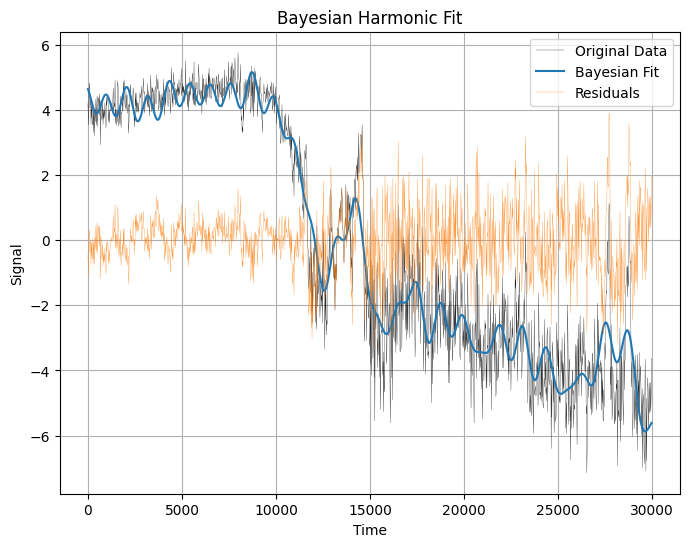

In [4]:
show_results(t, y, model, residuals)

In [5]:
params

,P,dP,A,dA,Phi,dPhi
0,43021.376158,675.825286,4.418621,0.045542,5.739929,0.034712
1,16258.547330,278.619128,0.836572,0.046969,3.619684,0.114944
10,9856.659748,168.084729,4.003301,0.042682,2.923990,2.922867
7,9829.475765,217.803382,1.032844,0.040344,2.874241,2.864878
8,9797.634146,142.539631,2.065586,0.039431,4.403858,2.540699
11,9772.044230,8.831096,8.008678,0.039310,5.956717,0.010199
9,9664.990558,134.326883,2.870961,0.051852,1.877332,2.542637
6,9485.081648,101.288420,0.734930,0.038811,1.671844,2.636755
5,9466.188259,210.959051,0.366141,0.038008,3.216071,2.962944
15,6323.655351,107.991404,0.286118,0.038549,3.699436,0.245532
